In [48]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
# Data preparation
from utils import (
    load_aadhaar_data,
    format_dates,
    merge_datasets,
    clean_merged_data,
    add_all_features,
    plot_state_map,
    plot_bar
)

demo, bio, enroll = load_aadhaar_data()
demo = format_dates(demo)
bio = format_dates(bio)
enroll = format_dates(enroll)

df = merge_datasets(demo, bio, enroll)
df = clean_merged_data(df)
df = add_all_features(df)

print(f"✓ Data ready: {len(df):,} rows")
df.head()


✓ Loaded demo data: 2,071,687 rows
✓ Loaded bio data: 1,861,108 rows
✓ Loaded enroll data: 1,006,007 rows
✓ Formatted date column to datetime
✓ Formatted date column to datetime
✓ Formatted date column to datetime
Merging datasets...
✓ Merged data: 2,310,875 rows, 11 columns
Cleaning merged data...
✓ Cleaned 7 numeric columns
Adding activity columns...
✓ Added 4 activity columns
Determining activity types...
✓ Added activity_type column
Adding temporal features...
✓ Added 4 temporal features
Adding ratio features...
✓ Added 4 ratio features
✓ All features added successfully
✓ Data ready: 2,310,875 rows


,date,state,district,pincode,demo_age_5_17,demo_age_17_,bio_age_5_17,bio_age_17_,age_0_5,age_5_17,...,total_activity,activity_type,day,day_of_week,month,is_weekend,demo_ratio,bio_ratio,enrol_ratio,is_inactive_day
0,2025-03-01,andaman & nicobar,Andamans,744101,0,0,16,193,0,0,...,209,1,1,5,3,1,0.00,1.00,0.00,0
1,2025-03-01,andaman & nicobar,Nicobar,744301,32,360,101,48,0,0,...,541,2,1,5,3,1,0.72,0.28,0.00,0
2,2025-03-01,andaman & nicobar,Nicobar,744302,0,0,15,12,0,0,...,27,1,1,5,3,1,0.00,1.00,0.00,0
3,2025-03-01,andaman & nicobar,Nicobar,744303,0,0,46,27,0,0,...,73,1,1,5,3,1,0.00,1.00,0.00,0
4,2025-03-01,andaman & nicobar,Nicobar,744304,0,0,16,14,0,0,...,30,1,1,5,3,1,0.00,1.00,0.00,0


# EDA (Exploratory Data Analysis)

In [51]:
# @title ### Unique Values in Each column
df.nunique()

,0
date,115
state,36
district,1021
pincode,19814
demo_age_5_17,756
demo_age_17_,3196
bio_age_5_17,2122
bio_age_17_,2214
age_0_5,671
age_5_17,624


In [52]:
# @title Are there any instances when all the columns had an update
from constants import NUMERIC_COLUMNS

isAllUpdated = (df[NUMERIC_COLUMNS] > 0).all(axis=1)
len(df[isAllUpdated])


9886

Yes. There are 9886 instances

### New groups

#### Total Activity in the states

In [53]:
state_totals = df.groupby("state", as_index=False)["total_activity"].sum()
state_totals = state_totals.sort_values(by="total_activity", ascending =False)
state_totals.head()

,state,total_activity
33,uttar pradesh,19138692
20,maharashtra,14649880
4,bihar,10321522
19,madhya pradesh,9330679
28,rajasthan,7161028


#### Total Activity in districts

In [54]:
district_totals = df.groupby("district")[["total_enrolments","total_demo_updates","total_bio_updates"]].sum().reset_index()
district_totals["total_updates"] = district_totals["total_demo_updates"] + district_totals["total_bio_updates"]
district_totals.sample(10)

,district,total_enrolments,total_demo_updates,total_bio_updates,total_updates
150,Bokaro *,2,0,3,3
711,Paschim Medinipur,18085,214180,148750,362930
483,Kheda,7567,52619,117161,169780
901,Surajpur,2977,42067,71822,113889
297,Fatehpur,12333,107120,117914,225034
392,Jalna,5590,79540,192692,272232
263,Dohad,13003,5212,15716,20928
859,Sivaganga,4446,34296,95190,129486
744,Puri,3731,32863,74923,107786
913,Tenkasi,1268,10020,10203,20223


#### Total Activity in the states (in lakhs)

In [55]:
state_totals_per_lakh  = state_totals.assign(total_activity_lakh=lambda x: x["total_activity"] / 1e5).reset_index()
state_totals_per_lakh.head(5)

,index,state,total_activity,total_activity_lakh
0,33,uttar pradesh,19138692,191.39
1,20,maharashtra,14649880,146.50
2,4,bihar,10321522,103.22
3,19,madhya pradesh,9330679,93.31
4,28,rajasthan,7161028,71.61


#### No Activity Days in States

In [56]:
all_states = df["state"].unique()
no_activity_instances = df[df["activity_type"] == -1]
no_activity_states = no_activity_instances.groupby("state").size().reindex(all_states, fill_value=0)
no_activity_states = no_activity_states.sort_values(ascending=False)
no_activity_states = no_activity_states.reset_index().rename(columns={0: "no_activity_days"})
no_activity_states.head()

,state,no_activity_days
0,andhra pradesh,251
1,karnataka,88
2,tamil nadu,63
3,west bengal,52
4,himachal pradesh,25


#### District Wise Mean Aggregates

In [57]:
district_df = df.groupby('district').agg({
    'demo_ratio':'mean',
    'bio_ratio':'mean',
    'enrol_ratio':'mean',
    'is_inactive_day':'mean',
    'total_activity':'mean'
}).reset_index()
district_df.sample(5)

,district,demo_ratio,bio_ratio,enrol_ratio,is_inactive_day,total_activity
327,Gonda,0.44,0.41,0.15,0.00,89.03
30,Amreli,0.41,0.47,0.12,0.00,32.07
62,Bagalkot,0.40,0.43,0.16,0.00,38.97
237,Dhalai,0.43,0.46,0.11,0.00,50.95
491,Kiphire,0.35,0.42,0.23,0.00,62.95


#### State Type: Enrolment / Demographic / Biometric Heavy

In [58]:
state_type = (
    df.groupby("state")["activity_type"]
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index(name="state_type")
)
state_type["state_type"] = state_type["state_type"].map({
    0: "Enrolment Heavy",
    1: "Biometric Heavy",
    2: "Demographic Heavy"
})
state_type.head()

,state,state_type
0,andaman & nicobar,Biometric Heavy
1,andhra pradesh,Demographic Heavy
2,arunachal pradesh,Demographic Heavy
3,assam,Demographic Heavy
4,bihar,Demographic Heavy


#### State Updates

In [59]:
state_activity = (df.groupby("state")[["total_enrolments","total_demo_updates","total_bio_updates"]]
                  .sum().sort_values(by=["total_enrolments", "total_demo_updates", "total_bio_updates"],ascending=False)
                 )
state_activity = state_activity.reset_index()
state_activity["updates"] = state_activity["total_demo_updates"] + state_activity["total_bio_updates"]
state_activity.head()

,state,total_enrolments,total_demo_updates,total_bio_updates,updates
0,uttar pradesh,1018629,8542328,9577735,18120063
1,bihar,609585,4814350,4897587,9711937
2,madhya pradesh,493970,2912938,5923771,8836709
3,west bengal,375340,3872737,2524619,6397356
4,maharashtra,369139,5054602,9226139,14280741


#### Top 10 States

In [60]:
top_10_states = state_activity.head(10)["state"]
bottom_10_states = state_activity.tail(10)["state"]

#### District Stats (Mean, Std)

In [61]:
district_daily = df.groupby(["district", "date"])["total_activity"].sum().reset_index()

district_stats = district_daily.groupby("district")["total_activity"].agg(["mean", "std"]).reset_index()
district_stats = district_stats.rename(columns={"mean": "mean_activity","std": "std_activity"})
district_stats.sample(10)

,district,mean_activity,std_activity
11,Ahmed Nagar,117.74,93.84
135,Bhiwani,1282.63,3256.47
448,Kanker,821.12,1491.83
230,Deeg,6.18,4.84
924,Thrissur,2032.72,4168.36
357,Haveri,1228.30,3582.49
91,Bankura,2502.18,4040.94
235,Devbhumi Dwarka,338.63,849.71
654,Narmada,536.26,1576.96
800,Salumbar,4.22,3.27


#### Presence timeline

In [62]:
presence = df.assign(active=(df["activity_type"] != -1).astype(int)).pivot_table(
          index="state",
          columns="date",
          values="active",
          aggfunc="max",
          fill_value=0
      )
presence = presence.sort_index(axis=1)
presence.head()

date,2025-03-01,2025-03-02,2025-03-09,2025-03-15,2025-03-20,2025-03-23,2025-03-26,2025-03-27,2025-03-28,2025-03-29,...,2025-12-21,2025-12-22,2025-12-23,2025-12-24,2025-12-25,2025-12-26,2025-12-27,2025-12-28,2025-12-29,2025-12-31
state,,,,,,,,,,,,,,,,,,,,,
andaman & nicobar,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
andhra pradesh,1,0,0,0,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
arunachal pradesh,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
assam,1,0,0,1,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
bihar,1,0,1,1,1,1,0,1,0,0,...,1,1,1,1,1,1,1,1,1,1


#### Action Type Dominance Transistion matrix

In [63]:
state_month_type = (df[df["activity_type"] != -1].groupby(["state", "month"])["activity_type"]
    .agg(lambda x: x.value_counts().idxmax()).reset_index(name="dominant_type")
)

assert "activity_type" in df.columns

transition_matrix = (
    state_month_type
    .pivot(index="state", columns="month", values="dominant_type")
    .sort_index(axis=1)
)

In [64]:
daily_activity = df.groupby("date")["total_activity"].sum().sort_index()
daily_activity

,total_activity
date,
2025-03-01,19469780
2025-03-02,109
2025-03-09,3404
2025-03-15,3102
2025-03-20,6218
...,...
2025-12-26,936752
2025-12-27,929328
2025-12-28,411672


## EDA on new features and groups

In [65]:
numeric_cols = [
    'demo_age_5_17','demo_age_17_',
    'bio_age_5_17','bio_age_17_',
    'age_0_5','age_5_17','age_18_greater',
    'total_demo_updates','total_bio_updates',
    'total_enrolments','total_activity',
    'demo_ratio','bio_ratio','enrol_ratio'
]

df[numeric_cols].describe()

,demo_age_5_17,demo_age_17_,bio_age_5_17,bio_age_17_,age_0_5,age_5_17,age_18_greater,total_demo_updates,total_bio_updates,total_enrolments,total_activity,demo_ratio,bio_ratio,enrol_ratio
count,2310875.00,2310875.00,2310875.00,2310875.00,2310875.00,2310875.00,2310875.00,2310875.00,2310875.00,2310875.00,2310875.00,2310875.00,2310875.00,2310875.00
mean,2.10,19.23,14.81,15.38,1.53,0.74,0.07,21.33,30.19,2.35,53.87,0.43,0.45,0.12
std,18.24,152.66,75.64,79.56,11.73,9.53,2.13,168.60,146.74,21.04,280.51,0.36,0.36,0.26
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,4.00,0.00,0.07,0.00
50%,0.00,3.00,2.00,2.00,0.00,0.00,0.00,4.00,4.00,0.00,12.00,0.43,0.43,0.00
75%,2.00,12.00,8.00,8.00,1.00,0.00,0.00,13.00,16.00,2.00,36.00,0.72,0.77,0.10
max,5380.00,32332.00,8002.00,7625.00,2688.00,1812.00,855.00,33884.00,13381.00,3965.00,45861.00,1.00,1.00,1.00


## Setting Up Visualization tools

In [66]:
import matplotlib.pyplot as plt
import geopandas as gpd
map_geojson = "/content/drive/MyDrive/uidai/INDIA_STATES.geojson"

# Visualisations

## Log Distribution of Total Activity

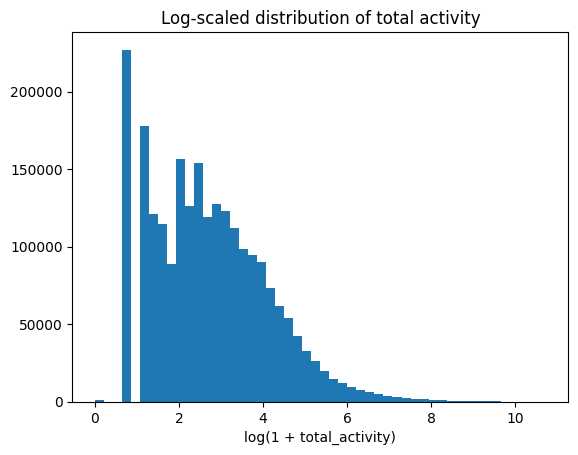

In [70]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(np.log1p(df['total_activity']), bins=50)
plt.xlabel('log(1 + total_activity)')
plt.title('Log-scaled distribution of total activity')
plt.show()

## ECDF of total Activity

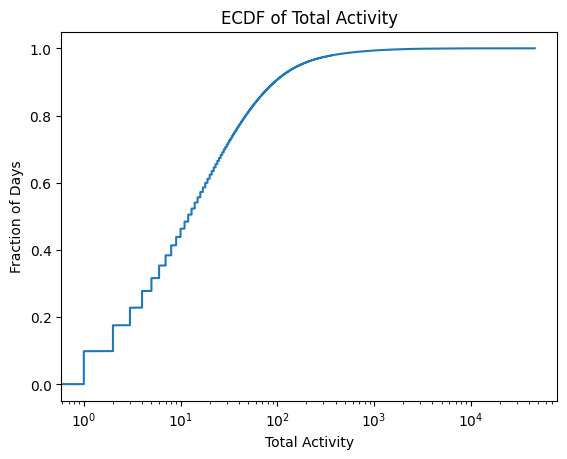

In [71]:
x = np.sort(df['total_activity'])
y = np.arange(1, len(x)+1) / len(x)

plt.plot(x, y)
plt.xlabel('Total Activity')
plt.ylabel('Fraction of Days')
plt.title('ECDF of Total Activity')
plt.xscale('log')
plt.show()

Over 90% of instances record fewer than 100 Aadhaar actions, confirming a highly skewed and decentralized workload pattern.

## Distribution of Demographic Ratio, Biometric Ratio and Enrolment Ratio

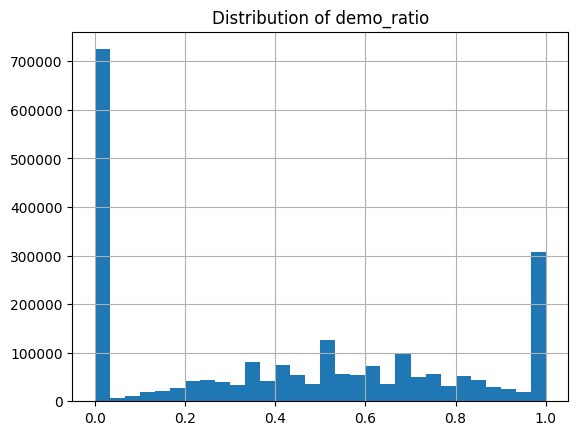

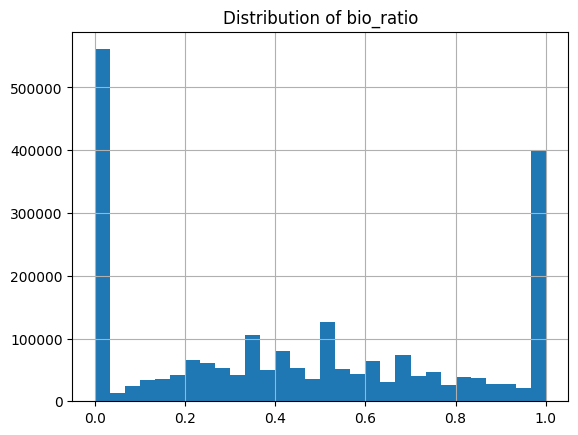

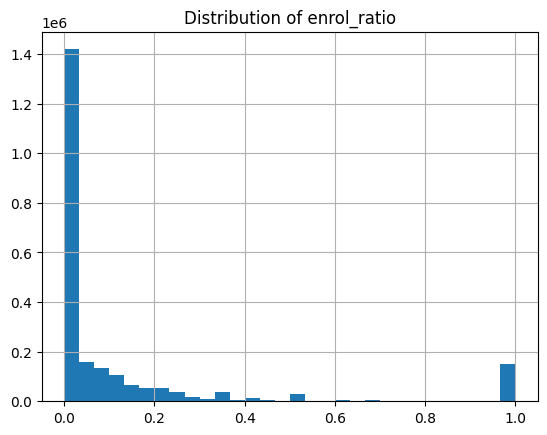

In [72]:
for c in ['demo_ratio','bio_ratio','enrol_ratio']:
    plt.figure()
    df[c].hist(bins=30)
    plt.title(f'Distribution of {c}')
    plt.show()

Standard linear histograms are avoided due to extreme right-skewness and zero inflation. Instead, log-scaled and cumulative distribution visualizations are used to reveal meaningful workload patterns.

## Bivariate Plots

### Boxplot of Total Activity grouped by day of week

<Figure size 800x400 with 0 Axes>

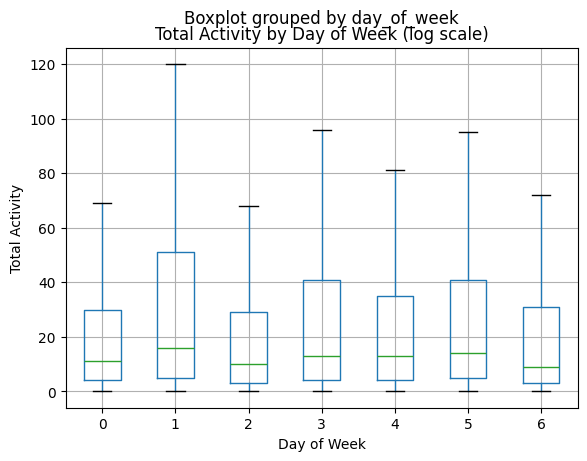

In [73]:
plt.figure(figsize=(8,4))
df.boxplot(column='total_activity', by='day_of_week', showfliers=False)
plt.title('Total Activity by Day of Week (log scale)')
plt.xlabel('Day of Week')
plt.ylabel('Total Activity')
plt.show()


### Scatterplot of instances (Demographic Ratio v/s Total Activity)

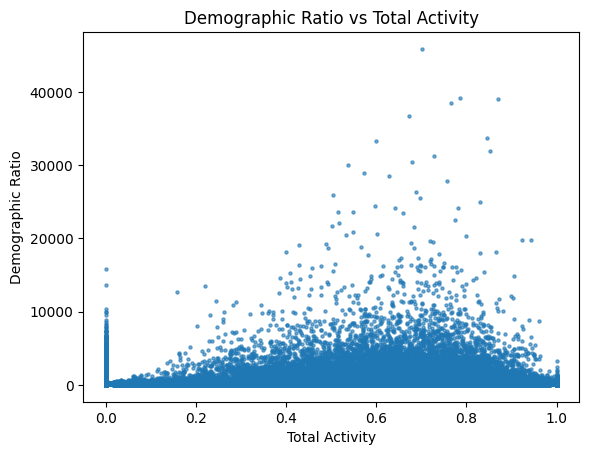

In [74]:
plt.scatter(
    df['demo_ratio'],
    df['total_activity'],
    alpha=0.6,
    s=5
)
plt.xlabel('Total Activity')
plt.ylabel('Demographic Ratio')
plt.title('Demographic Ratio vs Total Activity')
plt.show()

### Scatterplot of instances (Enrolments v/s Updates)

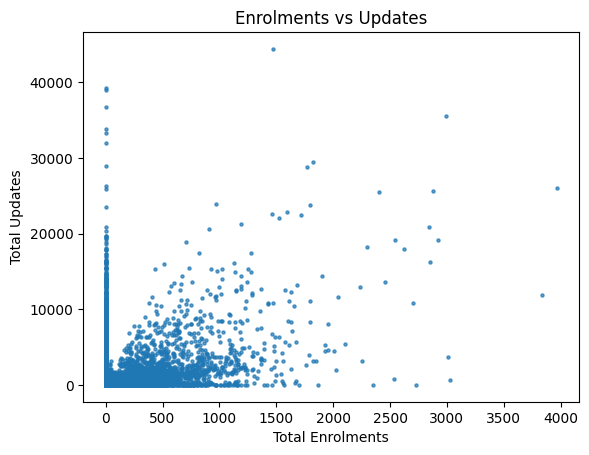

In [75]:
plt.scatter(
    df['total_enrolments'],
    df['total_demo_updates'] + df['total_bio_updates'],
    alpha=0.7,
    s=5
)
plt.xlabel('Total Enrolments')
plt.ylabel('Total Updates')
plt.title('Enrolments vs Updates')
plt.show()

### Boxplot of Total Activity grouped by Activity Type

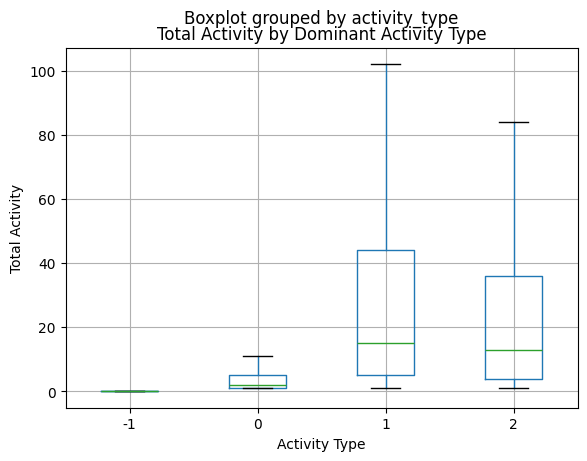

In [76]:
df.boxplot(
    column='total_activity',
    by='activity_type',
    showfliers=False
)
plt.title('Total Activity by Dominant Activity Type')
plt.xlabel('Activity Type')
plt.ylabel('Total Activity')
plt.show()

Monthly Median Total Activity

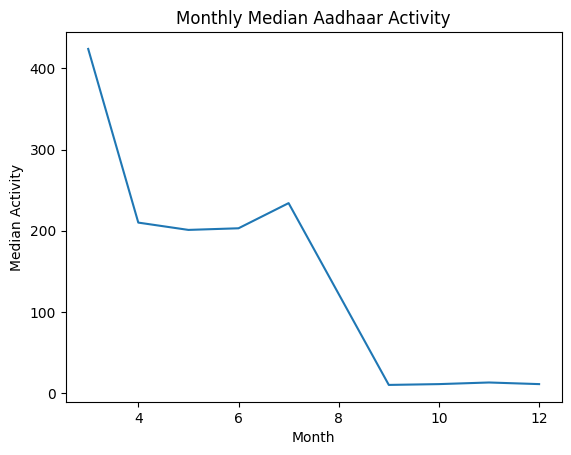

In [77]:
df.groupby('month')['total_activity'].median().plot()
plt.xlabel('Month')
plt.ylabel('Median Activity')
plt.title('Monthly Median Aadhaar Activity')
plt.show()

## Trivariate analysis

### Median Total Activity w.r.t. Day of Week and Month

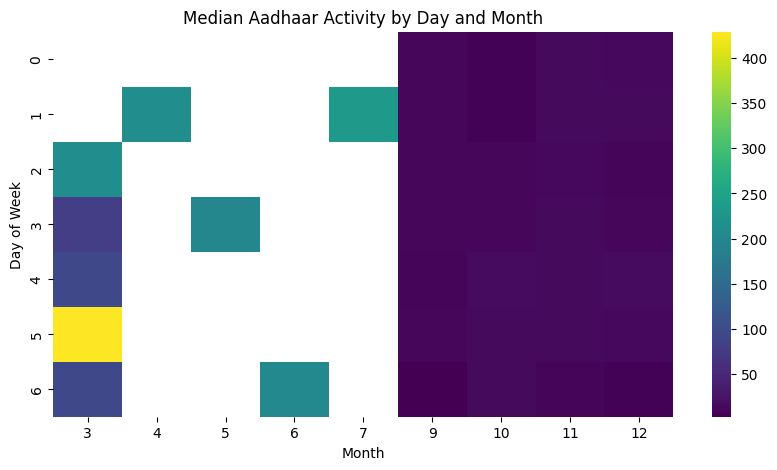

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = df.pivot_table(
    values='total_activity',
    index='day_of_week',
    columns='month',
    aggfunc='median'
)

plt.figure(figsize=(10,5))
sns.heatmap(pivot, cmap='viridis')
plt.title('Median Aadhaar Activity by Day and Month')
plt.xlabel('Month')
plt.ylabel('Day of Week')
plt.show()

### Mean Total Activity w.r.t. Month and Activity Type

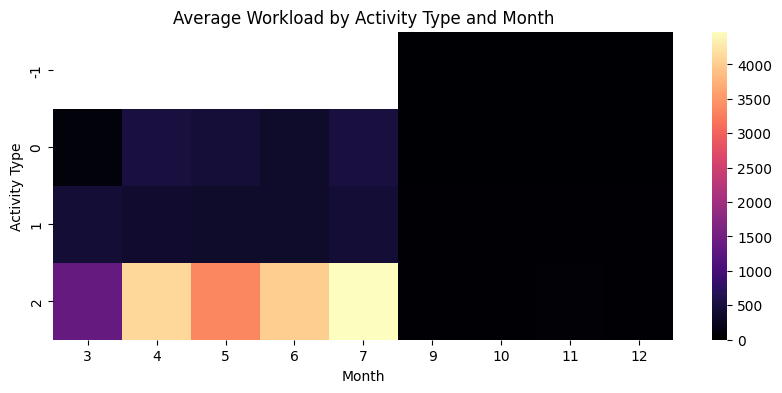

In [79]:
pivot = df.pivot_table(values='total_activity', index='activity_type', columns='month', aggfunc='mean')

plt.figure(figsize=(10,4))
sns.heatmap(pivot, cmap='magma')
plt.title('Average Workload by Activity Type and Month')
plt.xlabel('Month')
plt.ylabel('Activity Type')
plt.show()

### Median Demographic Ratio w.r.t. Total Activity level and Month

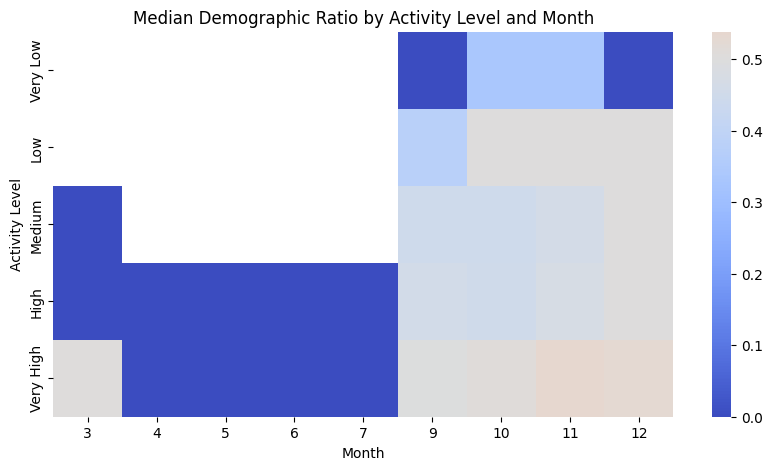

In [80]:
df['activity_bin'] = pd.qcut(
    df['total_activity'],
    q=5,
    labels=['Very Low','Low','Medium','High','Very High']
)
pivot = df.pivot_table(
    values='demo_ratio',
    index='activity_bin',
    columns='month',
    aggfunc='median',
    observed=True
)

plt.figure(figsize=(10,5))
sns.heatmap(pivot, cmap='coolwarm', center=0.5)
plt.title('Median Demographic Ratio by Activity Level and Month')
plt.xlabel('Month')
plt.ylabel('Activity Level')
plt.show()

## Total Actions (Demographic Updates + Biometric Updates + Enrolments) in Lakhs

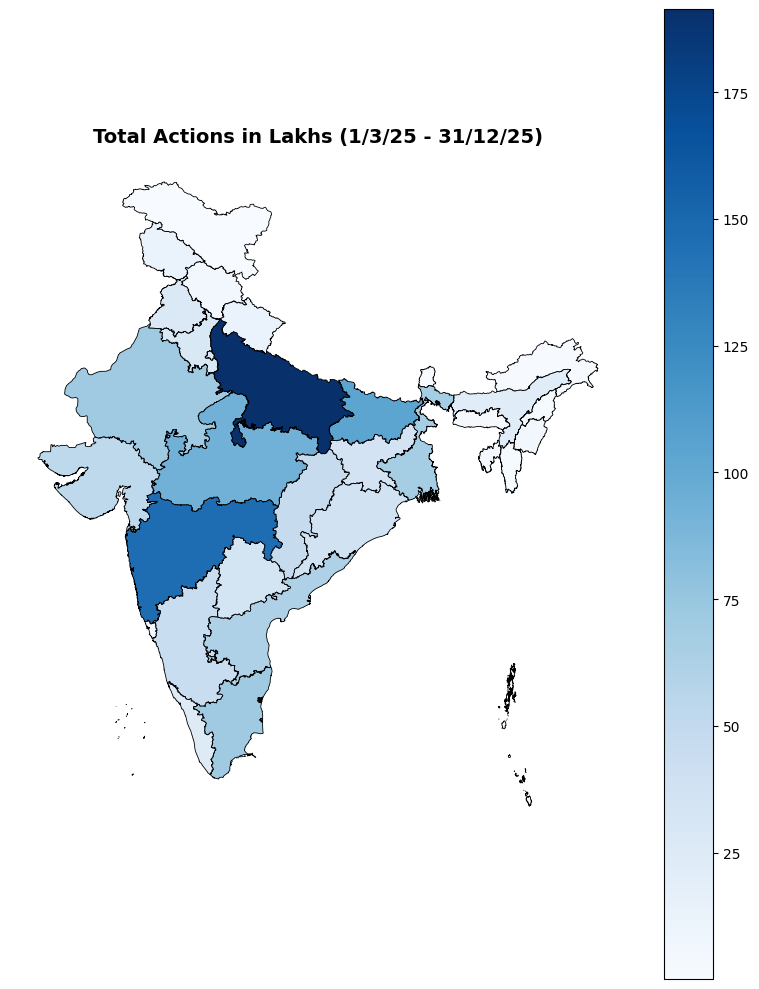

In [81]:
plot_state_map(state_totals_per_lakh, 'total_activity_lakh', "Total Actions in Lakhs (1/3/25 - 31/12/25)", "Blues")

## No. of No Activity Days during the time period

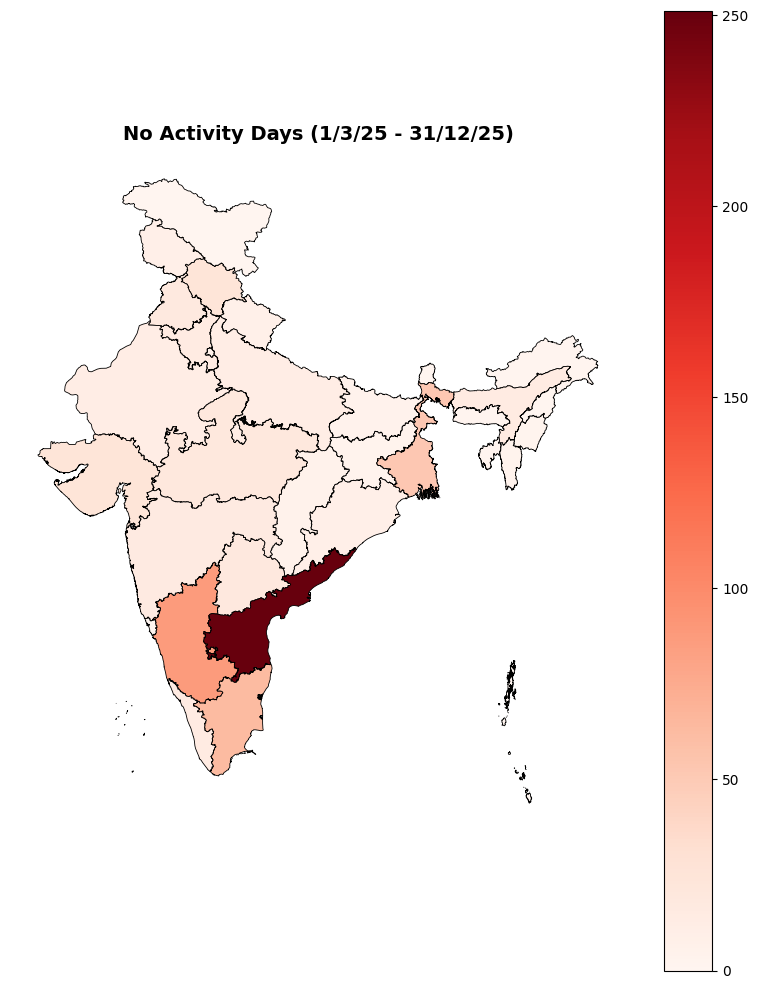

In [82]:
plot_state_map(no_activity_states, "no_activity_days", "No Activity Days (1/3/25 - 31/12/25)", colorScheme="Reds")

## Dominant Aadhaar Service Type Across States

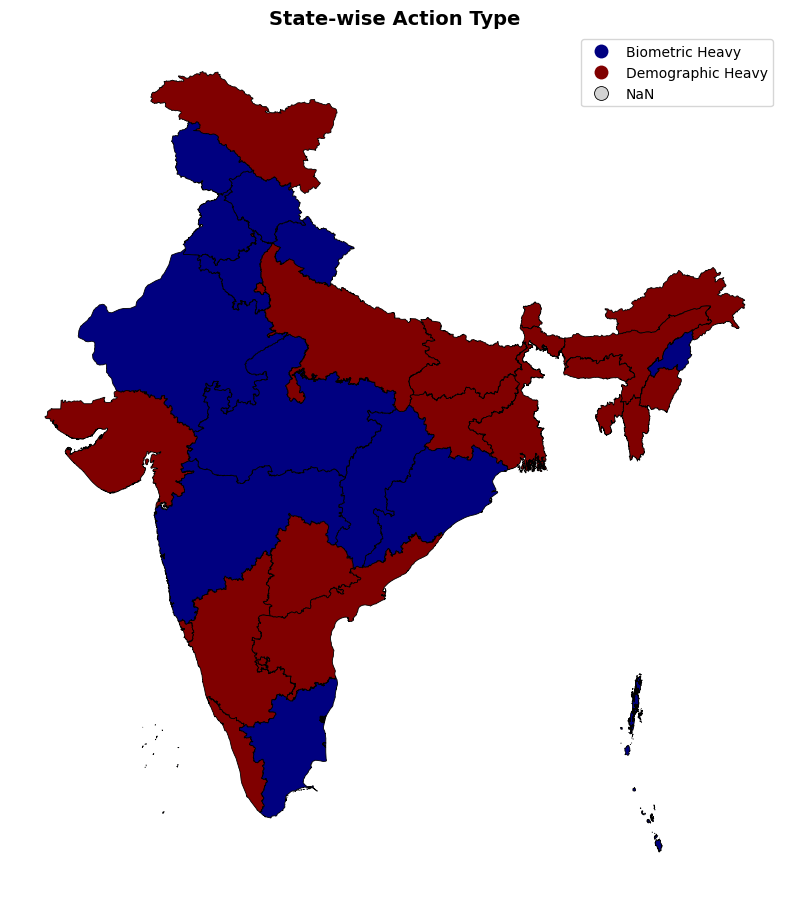

In [83]:
plot_state_map(state_type, "state_type", "State-wise Action Type", colorScheme="jet")

## State Wise Aadhaar Activity Presence by day

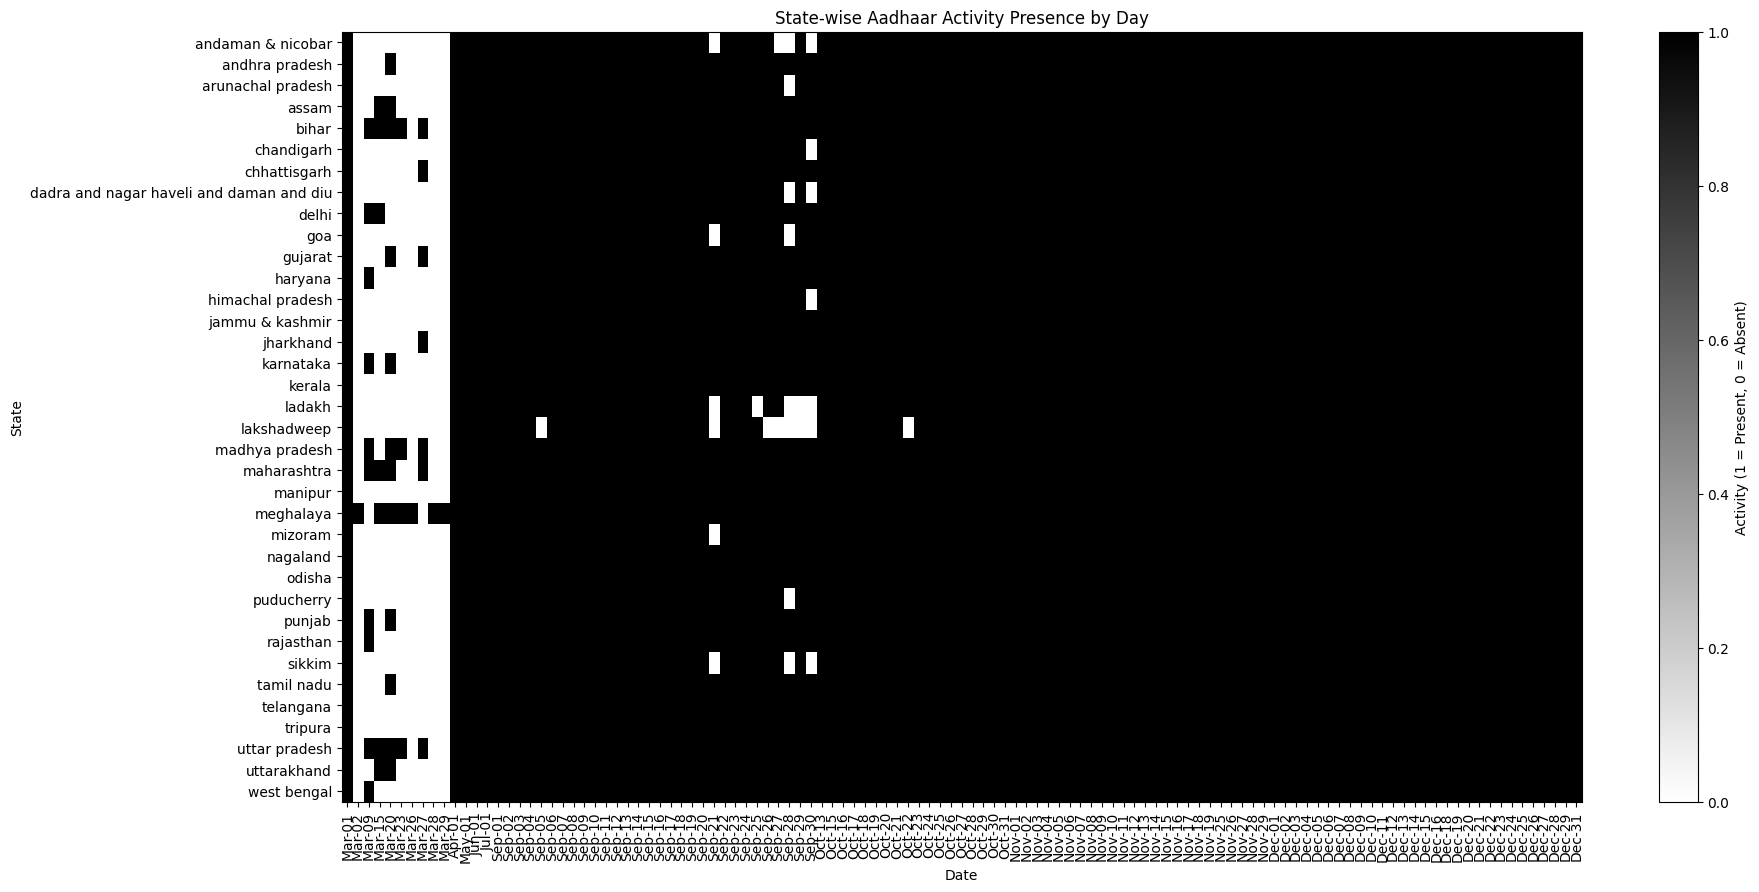

In [84]:
# @title
import matplotlib.pyplot as plt
dates = presence.columns
plt.figure(figsize=(20, 10))
plt.imshow(presence, aspect="auto", cmap="grey_r")
plt.colorbar(label="Activity (1 = Present, 0 = Absent)")
month_periods = dates.to_period("M")
month_start_mask = month_periods != month_periods.shift()
tick_positions = [i for i, v in enumerate(month_start_mask) if v]
tick_labels = dates[month_start_mask].strftime("%b-%d")

plt.xticks(tick_positions, tick_labels, rotation=90)
plt.yticks(range(len(presence.index)), presence.index)
plt.xlabel("Date")
plt.ylabel("State")
plt.title("State-wise Aadhaar Activity Presence by Day")

plt.show()

## Temporal Patterns of Aadhaar Activity Dominance by State

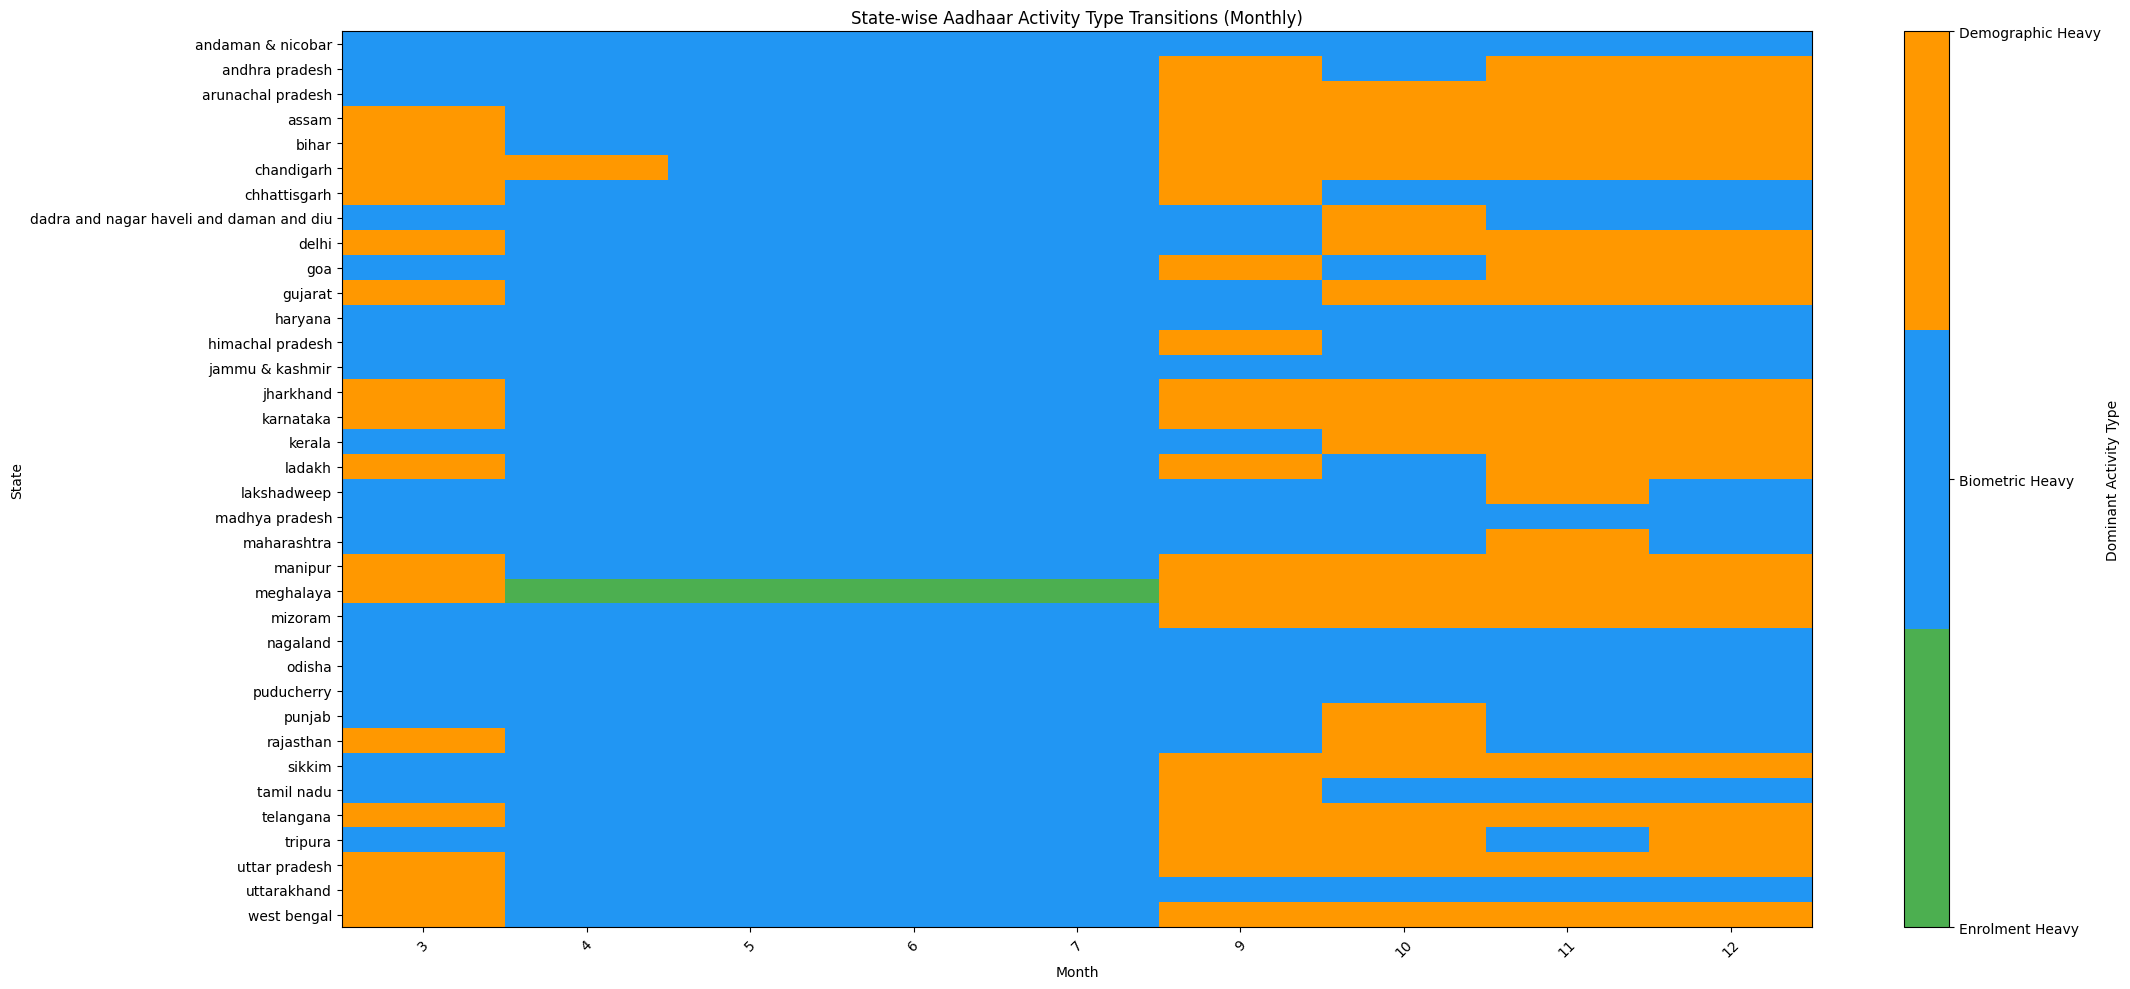

In [85]:
# @title
from matplotlib.colors import ListedColormap

cmap = ListedColormap(["#4CAF50","#2196F3","#FF9800"])

plt.figure(figsize=(22, 10))
plt.imshow(transition_matrix, aspect="auto", cmap=cmap)

plt.yticks(range(len(transition_matrix.index)), transition_matrix.index)
plt.xticks(range(len(transition_matrix.columns)), transition_matrix.columns.astype(str), rotation=45)

plt.xlabel("Month")
plt.ylabel("State")
plt.title("State-wise Aadhaar Activity Type Transitions (Monthly)")

cbar = plt.colorbar(ticks=[0, 1, 2], label="Activity Type")
cbar.ax.set_yticklabels(["Enrolment Heavy", "Biometric Heavy", "Demographic Heavy"])
cbar.set_label("Dominant Activity Type")

plt.tight_layout()
plt.show()

## Top 10 States by No Activity Days

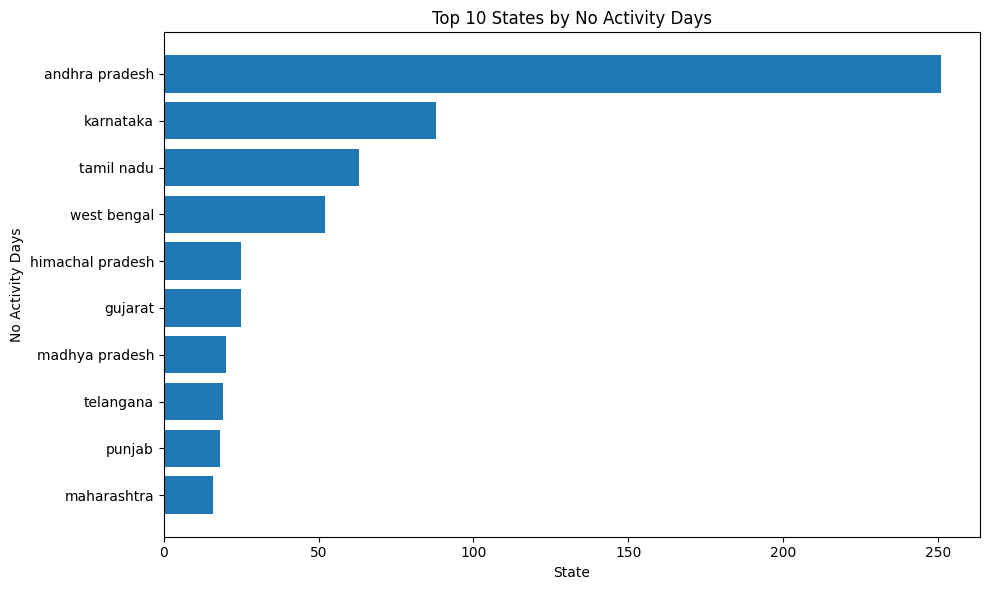

In [86]:
plot_bar(no_activity_states,x_col='state', y_col='no_activity_days', title="Top 10 States by No Activity Days", xlabel="State", ylabel="No Activity Days", horizontal=True, top_n=10)

## State wise Aadhaar Action Composition

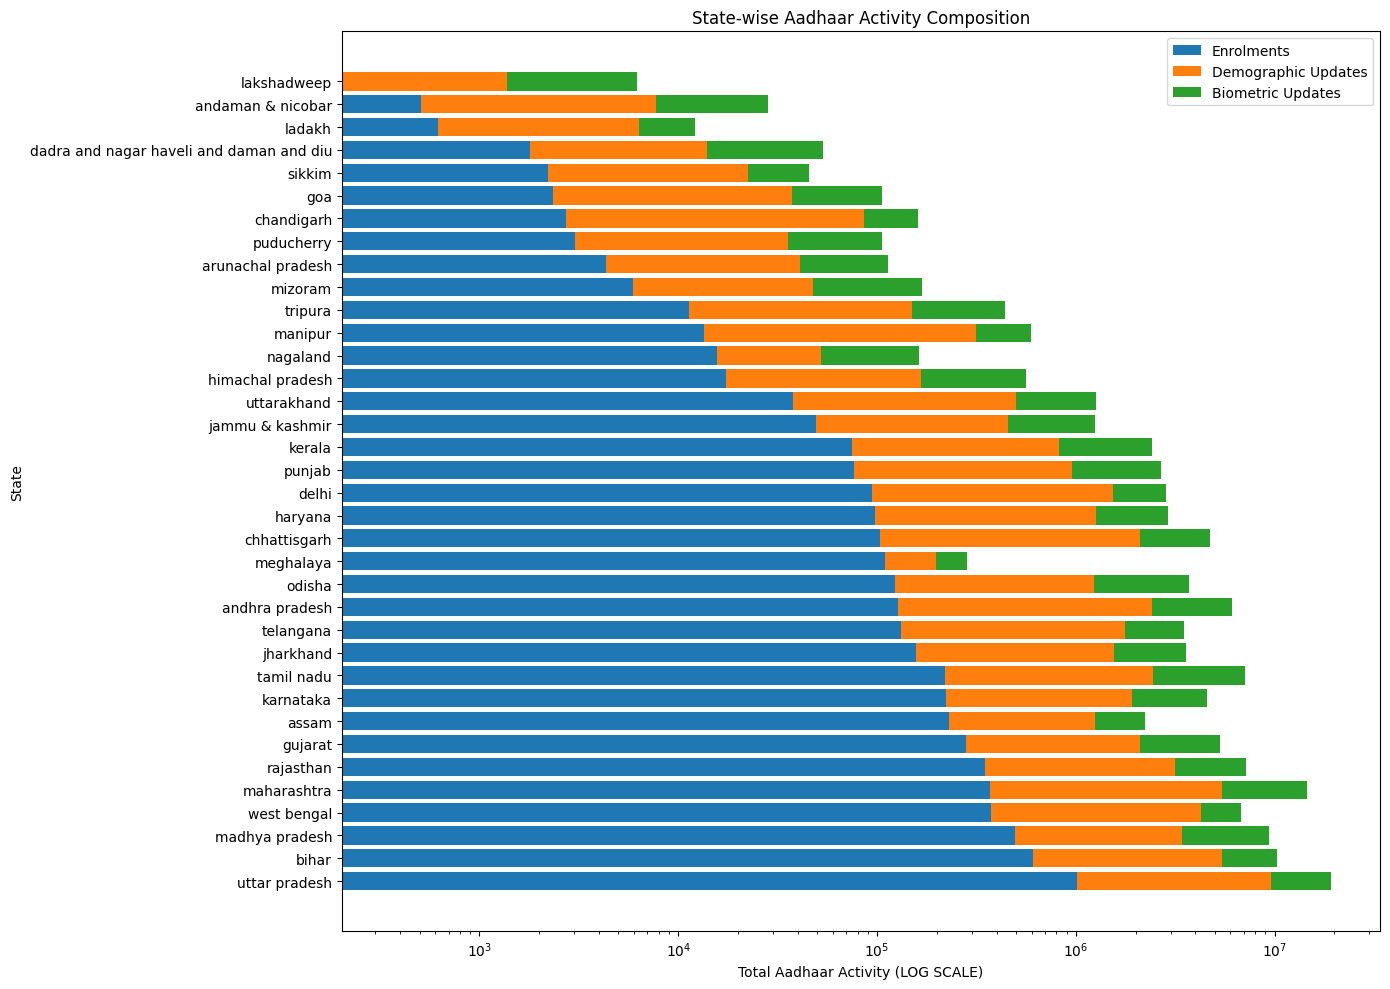

In [87]:
# @title
plt.figure(figsize=(14, 10))

plt.barh(state_activity['state'], state_activity["total_enrolments"], label="Enrolments")
plt.barh(state_activity['state'], state_activity["total_demo_updates"], left=state_activity["total_enrolments"], label="Demographic Updates")
plt.barh(state_activity['state'], state_activity["total_bio_updates"], left=state_activity["total_enrolments"] + state_activity["total_demo_updates"], label="Biometric Updates")

plt.xscale("log")
plt.xlabel("Total Aadhaar Activity (LOG SCALE)")
plt.ylabel("State")
plt.title("State-wise Aadhaar Activity Composition")

plt.legend()
plt.tight_layout()
plt.show()

## Daily Total Aadhaar activity Across India

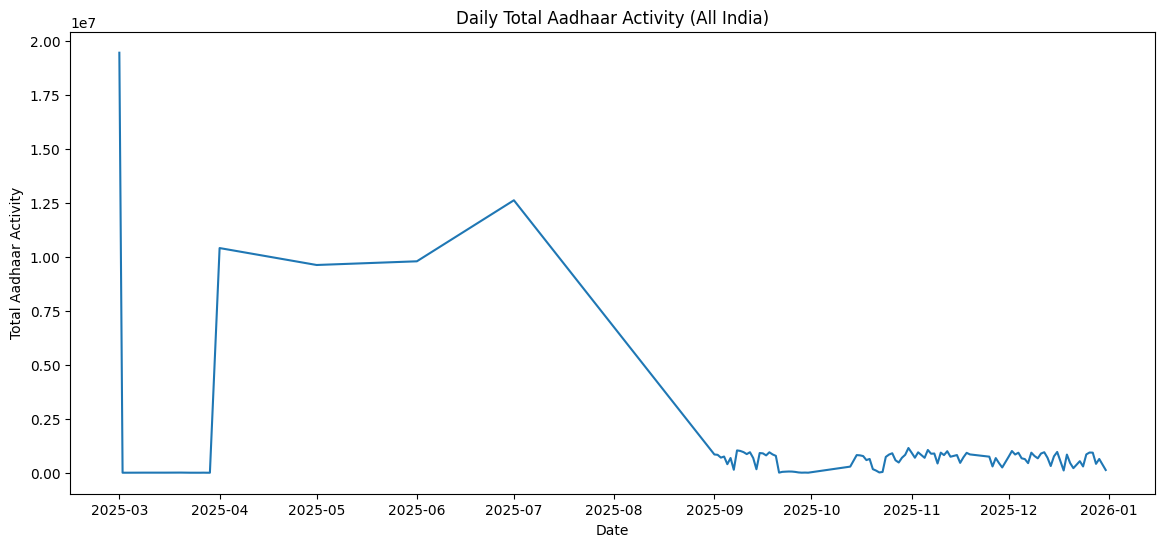

In [88]:
plt.figure(figsize=(14, 6))
plt.plot(daily_activity.index, daily_activity.values)

plt.xlabel("Date")
plt.ylabel("Total Aadhaar Activity")
plt.title("Daily Total Aadhaar Activity (All India)")

plt.show()

## Interactive Scatterplot of Districts' Daily Total Activity Mean v/s Std

In [89]:
# @title
import plotly.express as px

fig = px.scatter(
    district_stats,
    x="mean_activity",
    y="std_activity",
    hover_name="district",
    labels={
        "mean_activity": "Mean Daily Activity",
        "std_activity": "Activity Volatility (Std Dev)"
    },
    title="District Behaviour: Activity Level vs Volatility"
)

fig.update_traces(marker=dict(size=8, opacity=0.7))
fig.show()

## Interactive Scatterplot of Districts' Total Enrolments vs Total Updates

In [90]:
# @title
fig = px.scatter(
    district_totals,
    x="total_enrolments",
    y="total_updates",
    hover_name="district",
    labels={
        "total_enrolments": "Total Enrolments",
        "total_updates": "Total Updates"
    },
    title="District Behaviour: Enrolments vs Updates"
)

fig.show()

## Interactive Sunburst of Top 10 and Bottom 10 States' Update Composition

In [91]:
sunburst_base = pd.concat([
    state_activity[["state", "total_bio_updates"]].rename(columns={"total_bio_updates": "value"}).assign(activity="Biometric Updates"),
    state_activity[["state", "total_demo_updates"]].rename(columns={"total_demo_updates": "value"}).assign(activity="Demographic Updates")
])
sunburst_base = sunburst_base[sunburst_base["value"] > 0]

sunburst_top10 = sunburst_base[sunburst_base["state"].isin(top_10_states)]
sunburst_bottom10 = sunburst_base[sunburst_base["state"].isin(bottom_10_states)]

In [92]:
# @title
from plotly.subplots import make_subplots
fig_top = px.sunburst(sunburst_top10, path=["state", "activity"], values="value", color="state", title="Top 10 States: Aadhaar Update Composition")
fig_top.update_traces( textinfo="label+percent parent", insidetextorientation="radial", marker=dict(line=dict(color="white", width=1)))
fig_bottom = px.sunburst(sunburst_bottom10, path=["state", "activity"], values="value", color="state", title="Bottom 10 States: Aadhaar Update Composition")
fig_bottom.update_traces( textinfo="label+percent parent", insidetextorientation="radial", marker=dict(line=dict(color="white", width=1)))

fig = make_subplots(rows=1, cols=2,
    specs=[[{"type": "sunburst"}, {"type": "sunburst"}]],
    subplot_titles=["Top 10 States: Aadhaar Update Composition", "Bottom 10 States: Aadhaar Update Composition"]
)

fig.add_trace(fig_top.data[0], row=1, col=1)
fig.add_trace(fig_bottom.data[0], row=1, col=2)

fig.update_layout(height=650, showlegend=False, margin=dict(t=60, l=0, r=0, b=0))
fig.show()

# Models

LINEAR REGRESSION: Predicting Total Activity

Dataset Split:
  Training samples: 1,848,700
  Testing samples: 462,175
  Features: ['day', 'month', 'is_weekend']

Metric               Training        Testing        
--------------------------------------------------
MSE                       70,963.17      70,864.54
RMSE                         266.39         266.20
R² Score                     0.0984         0.0985

Feature Importance (by coefficient magnitude):
--------------------------------------------------
  month                 -46.95
  is_weekend             20.09
  day                    -2.57

Intercept: 572.66

LOGISTIC REGRESSION: Classifying Activity Type

Dataset Split:
  Training samples: 1,848,140
  Testing samples: 462,035
  Features: ['demo_ratio', 'bio_ratio', 'enrol_ratio', 'day_of_week', 'month']
  Classes: [np.int64(0), np.int64(1), np.int64(2)]

Metric               Training        Testing        
--------------------------------------------------
Accuracy      

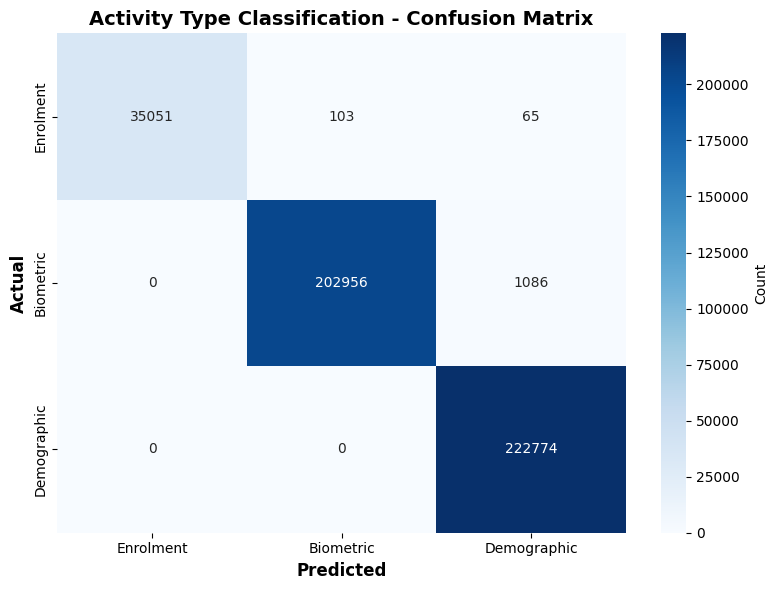

In [93]:
# Train all ML models with proper metrics
from utils import train_activity_predictor, train_activity_classifier, train_activity_clusters, plot_confusion_matrix

# Train regression and classification on full data
results = {}
results['regression'] = train_activity_predictor(df)
results['classification'] = train_activity_classifier(df)

# Train clustering on sample (faster)
df_sample = df.sample(n=100000, random_state=42)
print(f"\nUsing {len(df_sample):,} samples for clustering (faster)")
results['clustering'] = train_activity_clusters(df_sample)


# Visualize confusion matrix
cm = results['classification']['metrics']['confusion_matrix']
class_names = ['Enrolment', 'Biometric', 'Demographic']
plot_confusion_matrix(cm, class_names, title='Activity Type Classification - Confusion Matrix')


## Z Score of days

In [94]:
df['activity_zscore'] = (
    df.groupby('district')['total_activity']
      .transform(lambda x: (x - x.mean()) / x.std())
)

#### Anomolous Days a district-pincode had a z-score > 3

In [95]:
anomaly_days = df[df['activity_zscore'].abs() > 3]
anomaly_days[['date', 'state', 'district', 'pincode',
     'total_activity', 'activity_zscore', 'activity_type']].sort_values('activity_zscore', ascending=False)

,date,state,district,pincode,total_activity,activity_zscore,activity_type
17794,2025-03-01,telangana,Karimnagar,505001,5382,61.16,2
108547,2025-07-01,uttarakhand,Pauri Garhwal,246149,4194,48.74,2
106065,2025-07-01,telangana,Nalgonda,508001,4572,46.57,2
20171,2025-03-01,uttar pradesh,Rae Bareli,229001,10310,45.84,2
105706,2025-07-01,telangana,Karimnagar,505001,3966,45.01,2
...,...,...,...,...,...,...,...
42927,2025-04-01,west bengal,Hooghly,712123,339,3.00,1
8941,2025-03-01,kerala,Kottayam,686512,88,3.00,1
8952,2025-03-01,kerala,Kottayam,686532,88,3.00,1
11260,2025-03-01,maharashtra,Nagpur,440016,809,3.00,1


#### Total no. of times a district had a with z-score > 3

In [96]:
anomaly_days['district'].value_counts().head(10)

,count
district,
Thrissur,306
Kottayam,239
Kollam,232
Palakkad,223
Ernakulam,223
Thiruvananthapuram,217
Bangalore,201
Malappuram,197
Kannur,197


This is very high. Hence we'll only consider the top 10% instances of total activity, and try to predict if the next day will be high load

In [98]:
# Create previous day activity feature
df['prev_day_activity'] = df.groupby(['district','pincode'])['total_activity'].shift(1).fillna(0)

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

threshold = df['total_activity'].quantile(0.9)
df['is_high_load'] = (df['total_activity'] >= threshold).astype(int)

X = df[['prev_day_activity','month','is_weekend',
     'demo_ratio','bio_ratio','enrol_ratio']]

y = df['is_high_load']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

load_predicter_model = LogisticRegression(max_iter=1000)
load_predicter_model.fit(X_train, y_train)

accuracy_score(y_test, load_predicter_model.predict(X_test))


0.929035538486504

# Pincode Level Analysis

In [101]:
pincode_profile = df.groupby("pincode").agg(
    mean_activity=("total_activity", "mean"),
    std_activity=("total_activity", "std"),
    median_activity=("total_activity", "median"),

    enrol_share=("enrol_ratio", "mean"),
    demo_share=("demo_ratio", "mean"),
    bio_share=("bio_ratio", "mean"),

    inactive_rate=("is_inactive_day", "mean"),
    weekend_rate=("is_weekend", "mean"),

    behaviour_switches=("activity_bin", "nunique"),
    high_load_rate=("is_high_load", "mean"),

    zscore_std=("activity_zscore", "std")
).reset_index()
pincode_profile.sample(10)

,pincode,mean_activity,std_activity,median_activity,enrol_share,demo_share,bio_share,inactive_rate,weekend_rate,behaviour_switches,high_load_rate,zscore_std
3948,307801,80.77,202.58,43.50,0.17,0.38,0.45,0.00,0.27,5,0.12,0.73
17950,785619,29.91,118.11,11.50,0.15,0.54,0.31,0.00,0.26,5,0.02,1.29
19584,847229,106.84,244.81,58.00,0.14,0.48,0.38,0.00,0.27,5,0.21,0.84
2791,246177,7.20,12.62,4.00,0.04,0.31,0.66,0.00,0.25,5,0.00,0.15
4515,341026,48.97,196.36,18.00,0.15,0.36,0.49,0.00,0.26,5,0.05,0.71
13378,636104,34.20,61.29,20.00,0.13,0.41,0.46,0.00,0.26,5,0.05,0.50
19698,851214,140.51,215.81,81.00,0.18,0.48,0.34,0.00,0.28,5,0.43,0.79
12582,623534,19.66,44.31,9.00,0.13,0.38,0.49,0.00,0.26,5,0.05,0.59
13907,670703,30.87,63.44,14.50,0.12,0.34,0.53,0.00,0.26,5,0.05,1.29
5319,388335,23.12,62.38,10.00,0.18,0.27,0.55,0.00,0.23,5,0.06,0.62


In [103]:
from sklearn.preprocessing import MinMaxScaler

cols = [
    "std_activity",
    "inactive_rate",
    "behaviour_switches",
    "high_load_rate",
    "zscore_std"
]

scaled = MinMaxScaler().fit_transform(pincode_profile[cols])

pincode_profile["anomaly_score"] = (
    0.3 * scaled[:, 0] +   # volatility
    0.25 * scaled[:, 1] +  # inactivity
    0.2 * scaled[:, 2] +   # behaviour churn
    0.15 * scaled[:, 3] +  # high load
    0.1 * scaled[:, 4]     # instability
)

In [104]:
from sklearn.ensemble import IsolationForest

features = [
    "mean_activity",
    "std_activity",
    "enrol_share",
    "demo_share",
    "bio_share",
    "inactive_rate",
    "behaviour_switches",
    "high_load_rate"
]

X = pincode_profile[features].fillna(0)

iso = IsolationForest(
    n_estimators=300,
    contamination=0.05,
    random_state=42
)

pincode_profile["iso_score"] = -iso.fit_predict(X)

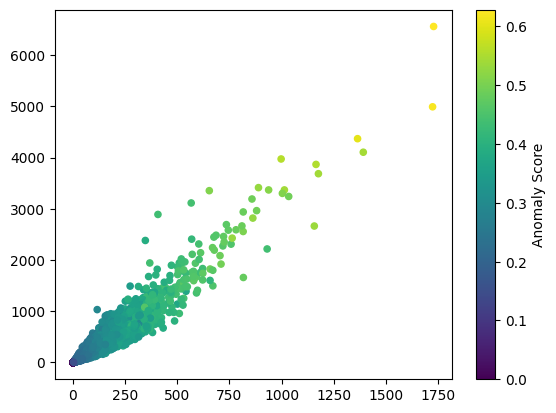

In [105]:
plt.scatter(
    pincode_profile["mean_activity"],
    pincode_profile["std_activity"],
    c=pincode_profile["anomaly_score"],
    cmap="viridis",
    s=20
)
plt.colorbar(label="Anomaly Score")

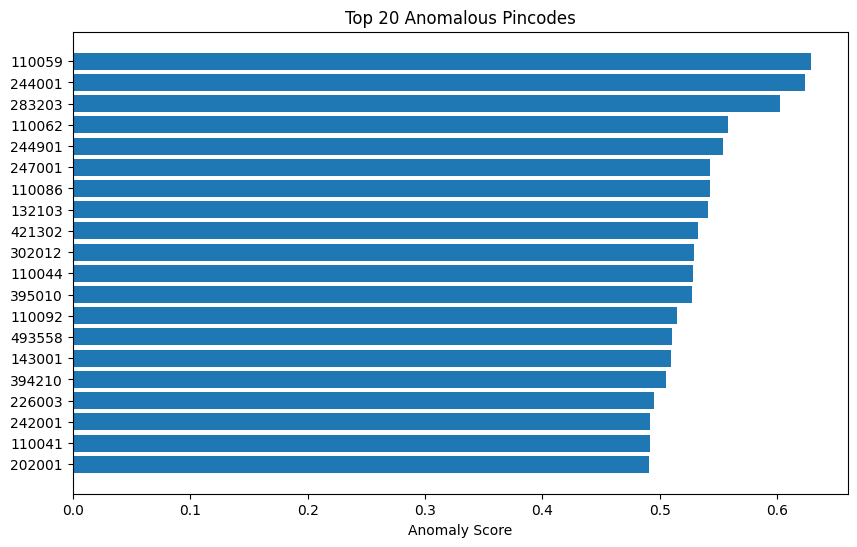

In [106]:
top_anom = pincode_profile.sort_values(
    "anomaly_score", ascending=False
).head(20)

plt.figure(figsize=(10,6))
plt.barh(
    top_anom["pincode"].astype(str),
    top_anom["anomaly_score"]
)
plt.gca().invert_yaxis()
plt.xlabel("Anomaly Score")
plt.title("Top 20 Anomalous Pincodes")
plt.show()